# LGSSM Demo - Random Walk

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple
from jax.random import multivariate_normal, split
from tqdm.notebook import tqdm, trange
from jax.random import multivariate_normal
from tensorflow_probability.substrates import jax as tfp
from jaxkf._src.functional.filter import kalman_step, filter_step_sequential, forward_filter
tfd = tfp.distributions
import jaxkf._src.lgssm as lgssm
from jaxkf._src.types import StatePrior, State, KFParams, KFParamsDist
from jaxkf._src.models.kalmanfilter import init_kf_params


import matplotlib.pyplot as plt

In [3]:
# from chex import dataclass
from dataclasses import dataclass

## Data

### State Transition Dynamics

We assume that we can fully describe the state when we have the `(x,y)` coordinates of the position and the `(x,y)` velocity. So we can write this as:

$$
\mathbf{z}_t = 
\begin{bmatrix}
z_t^1 \\ z_t^2 \\ \dot{z}_t^1 \\ \dot{z}_t^2
\end{bmatrix}
$$


where $z_t^d$ is the coordinate of the position and $\dot{z}^d$ is the velocity. 

We can describe the dynamics of the system using the following system of equations:

$$
\begin{aligned}
z_t^1 &= z_{t-1}^1 + \Delta_t \dot{z}_t^1 + \epsilon_t^1 \\
z_t^2 &= z_{t-1}^2 + \Delta_t \dot{z}_t^2 + \epsilon_t^2 \\
\dot{z}_t^1 &= \dot{z}_{t-1}^1 + \epsilon_t^3 \\
\dot{z}_t^2 &= \dot{z}_{t-1}^2 + \epsilon_t^4 \\
\end{aligned}
$$

This is a very simple formulation which takes a first order approximation to the change in position based on speed and we also assume constant velocity. Note, we also include some noise because we assume that some of the dynamics are noisy, i.e. there are random acceleration and position changes in the model. 


We can also put this into matrix formulation like so:

$$
\mathbf{z}_t = \mathbf{A}_t \mathbf{z}_{t-1} + \boldsymbol{\epsilon}_t
$$

where:

$$
\mathbf{A}_t = 
\begin{bmatrix}
1 & 0 & \Delta_t & 0 \\
0 & 1 & 0 & \Delta_t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \;\; \mathbf{A}_t \in \mathbb{R}^{4\times 4}
$$



---
### Emissions Model

We can only fully observe the locations (not the velocities). So this will be a lower dimensional vector of size 2-D. The system of equations are as follows:

$$
\begin{aligned}
x_t^1 &= z_t^1 + \delta_t^1 \\
x_t^2 &= z_t^2 + \delta_t^2 \\
\end{aligned}
$$

This is a very simple model where we assume we can extract the direct positions (plus some noise) from the state.

We can write this in an abbreviated matrix formulation:

$$
\mathbf{x}_t = \mathbf{C}_t \mathbf{z}_t + \delta_t
$$

where:

$$
\mathbf{C}_t = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}, \;\; \mathbf{C}_t \in \mathbb{R}^{2 \times 4}
$$

## Parameters

#### Experimental Params

In [164]:
state_dim = 4
obs_dim = 2

dt = 0.1
r = 0.5

# init prior params
mu0 = jnp.array([0., 0., 1., -1.])
Sigma0 = jnp.eye(4)

prior_dist = tfd.MultivariateNormalFullCovariance(loc=mu0, covariance_matrix=Sigma0)

kf_prior_true = StatePrior(mu0=mu0, Sigma0=Sigma0, prior=prior_dist)

In [165]:
# init transition params
transition_matrix = jnp.eye(4) + dt * jnp.eye(state_dim, k=2)
a = jnp.array([[dt**3/3, dt**2/2], [dt**2/2, dt]])
b = jnp.eye(obs_dim)
transition_noise = jnp.kron(a,b)

transition_noise_dist = tfd.MultivariateNormalFullCovariance(
    loc=jnp.zeros(state_dim), covariance_matrix=transition_noise
)

# init transition params
observation_matrix = jnp.eye(2, M=4)
observation_noise = r**2 * jnp.eye(2)  

observation_noise_dist = tfd.MultivariateNormalFullCovariance(
    loc=jnp.zeros(obs_dim), covariance_matrix=observation_noise
)

# PARAMS
kf_params_true = KFParamsDist(
    transition_matrix=transition_matrix,
    transition_noise=transition_noise,
    transition_noise_dist=transition_noise_dist,
    observation_matrix=observation_matrix,
    observation_noise=observation_noise,
    observation_noise_dist=observation_noise_dist,
)

In [166]:
transition_matrix

DeviceArray([[1. , 0. , 0.1, 0. ],
             [0. , 1. , 0. , 0.1],
             [0. , 0. , 1. , 0. ],
             [0. , 0. , 0. , 1. ]], dtype=float32)

#### Simple Params

In [174]:
state_dim = 4
obs_dim = 2

dt = 0.1
r = 0.01

# init prior params
mu0 = jnp.array([10., 8., 1., 0.])
Sigma0 = jnp.ones(4)

prior_dist = tfd.MultivariateNormalDiag(loc=mu0, scale_diag=Sigma0)

kf_prior_true = StatePrior(mu0=mu0, Sigma0=Sigma0, prior=prior_dist)

In [202]:
# init transition params
transition_matrix = jnp.eye(4) + dt * jnp.eye(state_dim, k=2)
transition_noise = jnp.ones(state_dim) * 0.001

transition_noise_dist = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(state_dim), scale_diag=transition_noise
)

# init transition params
observation_matrix = jnp.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])
observation_noise = jnp.ones(obs_dim) * 0.01

observation_noise_dist = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(obs_dim), scale_diag=observation_noise
)

# PARAMS
kf_params_true = KFParamsDist(
    transition_matrix=transition_matrix,
    transition_noise=transition_noise,
    transition_noise_dist=transition_noise_dist,
    observation_matrix=observation_matrix,
    observation_noise=observation_noise,
    observation_noise_dist=observation_noise_dist,
)

### Samples

In [203]:
from jaxkf._src.functional.sample import sample_event

def gen_samples(
    kf_prior, 
    kf_params, 
    num_samples: int=20, 
    num_time_steps: int=10, 
    seed: int=123,
    sample_prior: bool=False
):
    

    state_samples, obs_samples = sample_event(
        kf_prior, 
        kf_params, 
        seed=seed, 
        sample_shape=(num_samples,), 
        num_time_steps=num_time_steps,
        sample_prior=sample_prior
    )
    
    return state_samples, obs_samples

In [204]:
# init samples params
num_samples = 10
num_time_steps = 50
seed = 123
sample_prior = False

# generate samples
state_samples, obs_samples = gen_samples(
    kf_prior_true, kf_params_true, 
    num_samples=num_samples, 
    num_time_steps=num_time_steps, 
    seed=seed, 
    sample_prior=sample_prior
)

# check shapes
assert state_samples.shape == (num_samples, num_time_steps, state_dim)
assert obs_samples.shape == (num_samples, num_time_steps, obs_dim)

In [205]:
state_samples.shape, obs_samples.shape

((10, 50, 4), (10, 50, 2))

### Viz 

#### Sample State Trajectories

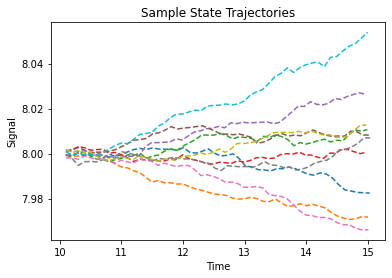

In [206]:
ts = jnp.arange(num_time_steps)

fig, ax = plt.subplots()

ax.plot(state_samples[..., 0].T, state_samples[..., 1].T, linestyle="--")

ax.set(xlabel="Time", ylabel="Signal", title="Sample State Trajectories")

plt.show()

#### Samples + Observations

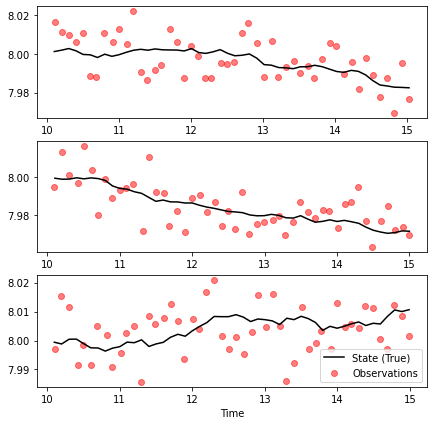

In [207]:
n_plots = 3

fig, axs = plt.subplots(nrows=n_plots, figsize=(7, 7))

for i, iax in enumerate(axs):
    

    iax.plot(state_samples[i, ..., 0], state_samples[i, ..., 1],label="State (True)", linestyle="-", color="black")
    iax.scatter(obs_samples[i, ..., 0], obs_samples[i, ..., 1],color="red", label="Observations", alpha=0.5)
#     ax.set(xlabel="Time", ylabel="Signal")

iax.set(xlabel="Time")
plt.legend()
plt.show()

## Filtering

In [208]:
from jaxkf._src.functional.filter import forward_filter

In [209]:
# forward filter
state = forward_filter(obs_samples, kf_prior_true, kf_params_true)


assert state.mu_filtered.shape[0] == obs_samples.shape[0] 
assert state.Sigma_filtered.shape[0] == obs_samples.shape[0] 

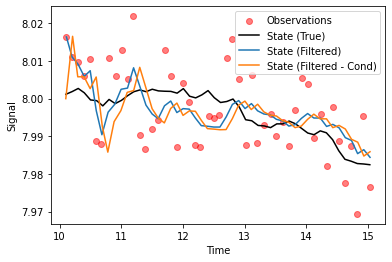

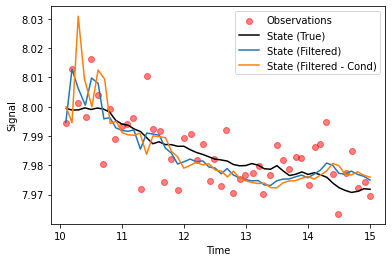

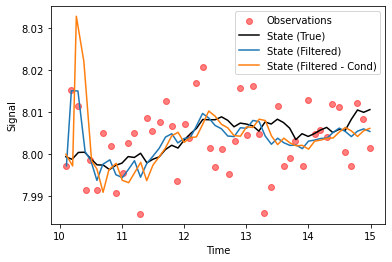

In [210]:
ts = jnp.arange(num_time_steps)

n_plots = 3

for batch_idx in jnp.arange(num_samples)[:n_plots]:
    fig, ax = plt.subplots()

    ax.scatter(obs_samples[batch_idx, ..., 0], obs_samples[batch_idx, ..., 1], color="red", label="Observations", alpha=0.5)
    ax.plot(state_samples[batch_idx, ..., 0], state_samples[batch_idx, ..., 1], label="State (True)", linestyle="-", color="black")
    ax.plot(state.mu_filtered[batch_idx, ..., 0], state.mu_filtered[batch_idx, ..., 1], label="State (Filtered)", linestyle="-")
    ax.plot(state.mu_cond[batch_idx, ..., 0], state.mu_cond[batch_idx, ..., 1], label="State (Filtered - Cond)", linestyle="-")
    ax.set(xlabel="Time", ylabel="Signal")

    plt.legend()
    plt.show()

## Model

In [211]:
import treex as tx
from jax.nn import softplus
from jaxkf._src.models.kalmanfilter import init_kf_params

### LGSSM

In [212]:
class LGSSM(tx.Module):
    # define free and fixed params
    # transition_matrix: jnp.ndarray = tx.Parameter.node()
    transition_noise: jnp.ndarray = tx.Parameter.node()
    # emission_matrix: jnp.ndarray = tx.Parameter.node()
    emission_noise: jnp.ndarray = tx.Parameter.node()
    # prior_mean: jnp.ndarray = tx.Parameter.node()
    # prior_cov: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, prior, params):
        """
        Here we unpack the tupes
        """
        # init prior
        self.prior_mean = prior.mu0
        self.prior_cov = prior.Sigma0
        
        # init parameters
        self.transition_matrix = params.transition_matrix
        self.transition_noise = params.transition_noise
        self.emission_matrix = params.observation_matrix
        self.emission_noise = params.observation_noise
    
    def __call__(self, x):
        """Do filtering operation
        We pack up the tuples and push them through the filtering regime.
        """
        kf_params, kf_prior = init_params(
            self.prior_mean, self.prior_cov,
            self.transition_matrix, self.transition_noise,
            self.emission_matrix, self.emission_noise
        )
        

        state = forward_filter(x, kf_prior, kf_params)
                
        return state.mu_filtered, state.Sigma_filtered, state.log_likelihoods
        


In [213]:
def init_params(
    mu0, Sigma0, 
    transition_matrix, transition_noise,
    observation_matrix, observation_noise):
    
        state_dim = mu0.shape[0]
        obs_dim = observation_matrix.shape[0]
        
        # PRIOR DIST
        prior_dist = tfd.MultivariateNormalDiag(
            loc=mu0, 
            scale_diag=Sigma0
        )

        kf_prior = StatePrior(
            mu0=mu0, 
            Sigma0=Sigma0, 
            prior=prior_dist
        )
        
        # TRANSITION NOISE
        transition_noise = softplus(transition_noise + 1e-4)
        
        transition_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(state_dim), scale_diag=transition_noise
        )
        
        observation_noise = softplus(observation_noise + 1e-4)

        observation_noise_dist = tfd.MultivariateNormalDiag(
            loc=jnp.zeros(obs_dim), scale_diag=observation_noise
        )

        # PARAMS
        kf_params = KFParamsDist(
            transition_matrix=transition_matrix,
            transition_noise=transition_noise,
            transition_noise_dist=transition_noise_dist,
            observation_matrix=observation_matrix,
            observation_noise=observation_noise,
            observation_noise_dist=observation_noise_dist,
        )
        
        
        return kf_params, kf_prior 

#### Init Params

In [140]:
dt = 0.01
r = 0.05

# init prior params
mu0 = jnp.array([0., 0., 1., -1.])
Sigma0 = 0.01 * jnp.ones(4)


# init transition params
transition_matrix = jnp.eye(4) + dt * jnp.eye(state_dim, k=2)
a = jnp.array([[dt**3/3, dt**2/2], [dt**2/2, dt]])
b = jnp.eye(obs_dim)

# TRAINABLE
# transition_noise = jnp.kron(a,b)
transition_noise = 1.0 * jnp.ones(4)


# init transition params
observation_matrix = jnp.eye(2, M=4)

# TRAINABLE
observation_noise = r * jnp.ones(2)  

In [214]:
kf_params_prior, kf_prior_prior = init_params(
    mu0, Sigma0,
    transition_matrix, transition_noise,
    observation_matrix, observation_noise
)

In [215]:
# init model
lgssm_model = LGSSM(prior=kf_prior_prior, params=kf_params_prior).init(123)

# forward pass
mus, sigmas, log_probs = lgssm_model(obs_samples)

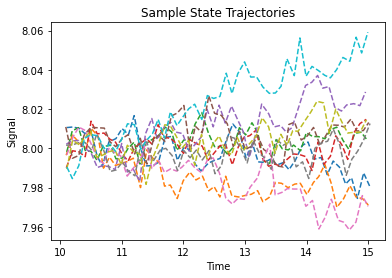

In [216]:
ts = jnp.arange(num_time_steps)

fig, ax = plt.subplots()

ax.plot(mus[..., 0].T, mus[..., 1].T, linestyle="--")

ax.set(xlabel="Time", ylabel="Signal", title="Sample State Trajectories")

plt.show()

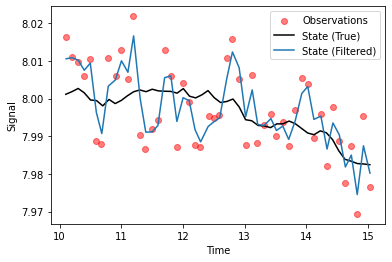

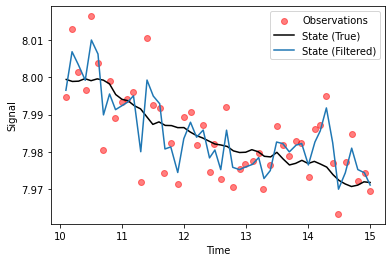

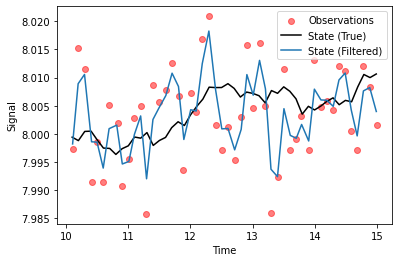

In [217]:
ts = jnp.arange(num_time_steps)

n_plots = 3

for batch_idx in jnp.arange(num_samples)[:n_plots]:
    fig, ax = plt.subplots()

    ax.scatter(obs_samples[batch_idx, ..., 0], obs_samples[batch_idx, ..., 1],color="red", label="Observations", alpha=0.5)
    ax.plot(state_samples[batch_idx, ..., 0], state_samples[batch_idx, ..., 1], label="State (True)", linestyle="-", color="black")
    ax.plot(mus[batch_idx, ..., 0], mus[batch_idx, ..., 1], label="State (Filtered)", linestyle="-")
    ax.set(xlabel="Time", ylabel="Signal")

    plt.legend()
    plt.show()

In [218]:
# differentiate only w.r.t. parameters
def loss_fn(params, model, x):
    # merge params into model
    model = model.merge(params)

    # forward transformation
    *_, log_prob = model(x)
    
    log_prob = log_prob.sum(axis=1)
    
    # calculate nll
    loss = - jnp.mean(log_prob)

    # the model may contain state updates
    # so it should be returned
    return loss, model

In [219]:
# get model parsm
model_params = lgssm_model.parameters()

# 1 pass through function
loss, _ = loss_fn(model_params, lgssm_model, obs_samples)
loss

DeviceArray(153.86934, dtype=float32)

### Train Step

In [220]:
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

(loss_, m_), grads_ = grad_fn(model_params, lgssm_model, obs_samples)

In [221]:
loss_

DeviceArray(153.86934, dtype=float32)

In [222]:
grads_.emission_noise

DeviceArray([16.628525, 16.676819], dtype=float32)

#### Optimizer

In [223]:
import optax

# init model
lgssm_model = LGSSM(prior=kf_prior_prior, params=kf_params_prior).init(123)

optimizer = tx.Optimizer(optax.adam(0.001)).init(lgssm_model)

### Train Step

In [224]:
# both model and optimizer are jit-able
@jax.jit
def train_step(model, x, optimizer):
    # select only the parameters
    params = model.parameters()

    (loss, model), grads = grad_fn(params, model, x)

    # update params and model
    params = optimizer.update(grads, params)
    model = model.merge(params)

    # return new model and optimizer
    return loss, model, optimizer

#### Training

In [225]:

from tqdm.notebook import trange, tqdm




n_iterations = 10_000
losses = []

train_data = obs_samples

with trange(n_iterations) as pbar:
    for i in pbar:
        
        loss, lgssm_model, optimizer = train_step(lgssm_model, train_data, optimizer)
        
        if i % 100 == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
        losses.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Final Params

In [226]:
final_params = lgssm_model.parameters()

#### Transition Model

In [227]:
final_params.transition_matrix, kf_params_true.transition_matrix

(DeviceArray([[1. , 0. , 0.1, 0. ],
              [0. , 1. , 0. , 0.1],
              [0. , 0. , 1. , 0. ],
              [0. , 0. , 0. , 1. ]], dtype=float32),
 DeviceArray([[1. , 0. , 0.1, 0. ],
              [0. , 1. , 0. , 0.1],
              [0. , 0. , 1. , 0. ],
              [0. , 0. , 0. , 1. ]], dtype=float32))

In [228]:
softplus(final_params.transition_noise), kf_params_true.transition_noise

(DeviceArray([0.06532634, 0.00222181, 0.2555163 , 0.00075165], dtype=float32),
 DeviceArray([0.001, 0.001, 0.001, 0.001], dtype=float32))

#### Emission Model

In [229]:
final_params.emission_matrix, kf_params_true.observation_matrix

(DeviceArray([[1, 0, 0, 0],
              [0, 1, 0, 0]], dtype=int32),
 DeviceArray([[1, 0, 0, 0],
              [0, 1, 0, 0]], dtype=int32))

In [230]:
softplus(final_params.emission_noise), kf_params_true.observation_noise

(DeviceArray([0.03801286, 0.00048313], dtype=float32),
 DeviceArray([0.01, 0.01], dtype=float32))

#### Prior

In [231]:
final_params.prior_mean, kf_prior_true.mu0

(DeviceArray([10.,  8.,  1.,  0.], dtype=float32),
 DeviceArray([10.,  8.,  1.,  0.], dtype=float32))

In [232]:
softplus(final_params.prior_cov), kf_prior_true.Sigma0

(DeviceArray([1.3132617, 1.3132617, 1.3132617, 1.3132617], dtype=float32),
 DeviceArray([1., 1., 1., 1.], dtype=float32))

#### Viz - Losses

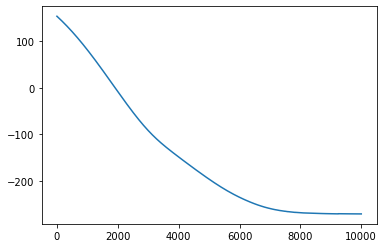

In [233]:
fig, ax = plt.subplots()

ax.plot(losses)
# ax.set(yscale="log")
plt.show()

### Results

In [234]:
# forward pass
mus, sigmas, log_probs = lgssm_model(obs_samples)

#### Filtered

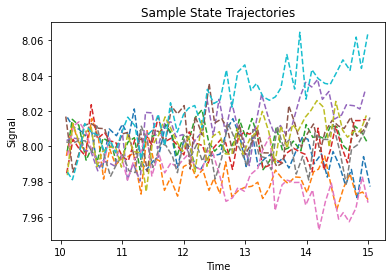

In [235]:
ts = jnp.arange(num_time_steps)

fig, ax = plt.subplots()

ax.plot(mus[..., 0].T, mus[..., 1].T, linestyle="--")

ax.set(xlabel="Time", ylabel="Signal", title="Sample State Trajectories")

plt.show()

#### Samples

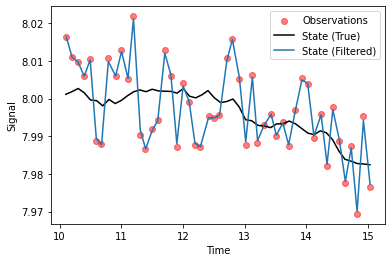

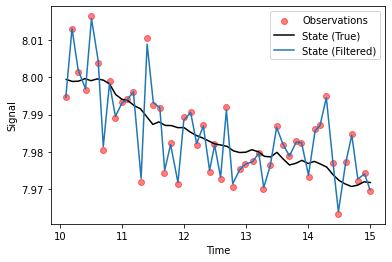

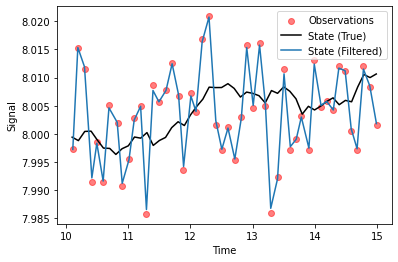

In [236]:
ts = jnp.arange(num_time_steps)

n_plots = 3

for batch_idx in jnp.arange(num_samples)[:n_plots]:
    fig, ax = plt.subplots()

    ax.scatter(obs_samples[batch_idx, ..., 0], obs_samples[batch_idx, ..., 1],color="red", label="Observations", alpha=0.5)
    ax.plot(state_samples[batch_idx, ..., 0], state_samples[batch_idx, ..., 1], label="State (True)", linestyle="-", color="black")
    ax.plot(mus[batch_idx, ..., 0], mus[batch_idx, ..., 1], label="State (Filtered)", linestyle="-")
    ax.set(xlabel="Time", ylabel="Signal")

    plt.legend()
    plt.show()